In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy

#Create rng Generator
rng = np.random.default_rng()

#Set default plot size
plt.rcParams['figure.figsize'] = (13,8)

# Consider the "three-peaks" PDF:

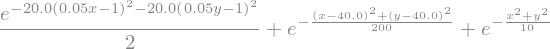

In [7]:
sy.init_printing()
pi, x, y = sy.symbols("pi x y", real = True)
with sy.evaluate(False):
    expr = sy.exp(sy.Rational(-1,10) * (x**2 + y**2)) + sy.Rational(1,2) * (sy.exp(sy.Rational(-1,20) * ((x-20.)**2 + (y-20.)**2))) + sy.exp(sy.Rational(-1,200) * ((x-40.)**2 + (y-40.)**2))
sy.powsimp(expr)

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def probdist(x, y, domain):
    if(domain[0][0] < x < domain[0][1]) and (domain[1][0] < y < domain[1][1]):
        f = np.exp(-1/10. * (x**2 + y**2))
        f += 0.5 * np.exp(-1/20. * ((x-20.)**2 + (y-20.)**2))
        f += np.exp(-1/200. * ((x-40.)**2 + (y-40.)**2))
    else:
        f = 0.
    return f

# proposal function uses a uniformly distributed step of maximum step-size δ. 
# (xn, yn) = (U[xc −δ,xc + δ], U[yc −δ,yc + δ])
def proposal(x, y, delta):
    newx = x + delta * (2. * rng.random() - 1.)
    newy = y + delta * (2. * rng.random() - 1.)
    return newx, newy

def metropolis_accept(newx, newy, oldx, oldy, domain):
    """acceptance function"""
    numer = probdist(newx, newy, domain);
    denom = probdist(oldx, oldy, domain);
    
    if rng.random() < numer/denom:
        accept = True
        x, y = newx, newy
    else:
        accept = False
        x, y = oldx, oldy
    return accept, x, y

def driver(nsteps=10000, delta=10., thin=10, x0 = 0.0, y0 = 0.0):
    """
    nsteps = 10000 # number of steps in the mcmc chain
    delta = 10. # delta for the proposal
    thin = 10 # save every 10th point
    x0, y0 = (0,0) # initial stte
    """
    # preliminaries;
    domain = np.array([[-30.,100.],[-30.,100.]])

    x = x0; y = y0

    AccRatio = 0. # target around 0.4
    NumSucc = 0 # number of successes

    # record of points sampled after thinning
    recs = np.zeros((int(nsteps/thin), 2))
    
    for iMCS in range(nsteps): # Main Loop
        # propose -> accept
        newx, newy = proposal(x, y, delta)
        accept, newx, newy = metropolis_accept(newx, newy, x, y, domain)
        if accept:
            NumSucc += 1
            x, y = newx, newy
            
        if (iMCS % thin) == 0: # record
            recs[int(iMCS/thin)] = [x, y];
            
    AccRatio = float(NumSucc)/float(nsteps)
    return recs, AccRatio

def plotChainDist(nsteps=10000, delta=10., thin=10, x0 = 0.0, y0 = 0.0, plot3D = False, plot3DMC = False):
    recs, acc = driver(nsteps, delta, thin, x0, y0)
    plt.plot(recs[:, 0], recs[:, 1],'k.', alpha = 0.5) #plot the actual guesses
    
    x = np.linspace(-10, 70, 100)
    X, Y = np.meshgrid(x, x)
    m, n = X.shape
    Z = np.zeros((m, n))
    domain = np.array([[-30.,100.],[-30.,100.]])
    for i in range(m):
        for j in range(n):
            Z[i, j] = probdist(X[i, j], Y[i, j], domain)
            
    plt.contourf(X, Y, Z, cmap=cm.OrRd) #make the actual contour of the 'spikes'
    plt.title('$\delta$ = {0:0.2f}'.format(delta), fontsize = 24)
    plt.axis('equal')
    plt.show()
    
    
    if plot3D:
        #Plot of 3-peaks function
        fig = plt.figure()
        ax = plt.axes(projection = '3d')
        ax.plot_surface(X, Y, Z, cmap = cm.OrRd, edgecolor = 'black')
        plt.show()
        
        if plot3DMC:
            #Plot of MC 3-peaks function
            X_MC, Y_MC = np.meshgrid(recs[:,0], recs[:,1])
            m_MC, n_MC = X_MC.shape
            Z_MC = np.zeros((m_MC, n_MC))
            for i in range(m_MC):
                for j in range(n_MC):
                    Z_MC[i, j] = probdist(X_MC[i, j], Y_MC[i, j], domain)
            fig = plt.figure()
            ax = plt.axes(projection = '3d')
            ax.plot_surface(X_MC, Y_MC, Z_MC, edgecolor = 'black')
            plt.show()
    
    #'traceplots'
    plt.subplot(121)
    plt.plot(recs[:, 0])
    plt.xlabel("MCS")
    plt.ylabel("$x_i$")
    plt.subplot(122)
    plt.plot(recs[:, 1])
    plt.xlabel("MCS")
    plt.ylabel("$y_i$")
    plt.show()

    Nburn = 100
    meanx, meany = np.mean(recs[Nburn:-1, 0]), np.mean(recs[Nburn:-1, 1])
    a = recs[Nburn:-1, 0] ** 2 + recs[Nburn:-1, 1] ** 2
    print("Acceptance Ratio = ", acc)
    print("mean x, y, a:", meanx, meany, np.mean(a))
    
    return recs, acc

## (i) Use visualization/traceplots to estimate reasonable choices for:  
- (a) $\delta$ in the proposal step  
- (b) thinning frequency  
- (c) the length of the burn-in period  
- (d) initial state

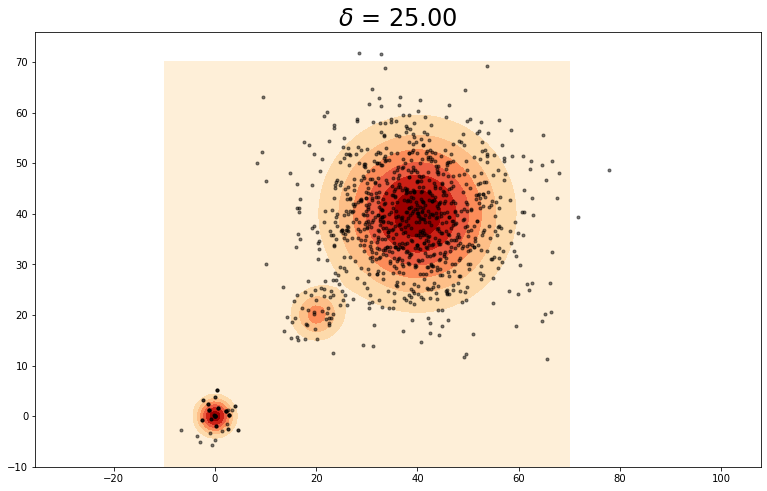

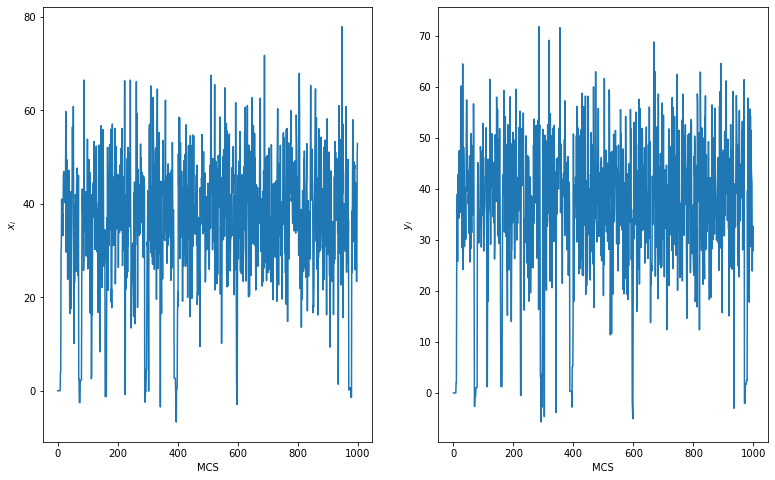

Acceptance Ratio =  0.3634
mean x, y, a: 36.70804181226656 36.79699444346876 3057.1119572866955


In [14]:
nsteps = 10000
delta = 25.
thinning = 10
x0, y0 = 0.0, 0.0

#rec, acc = driver(nsteps, delta, thinning, x0 = 0.0, y0 = 0.0)

rec, acc = plotChainDist(nsteps, delta, thinning, x0, y0)

## (ii) According to the Gelman-Rubin heuristic, how long should you run the simulation to ensure convergence?

In [10]:
def GelmanRubin(A, M, n):
    """A is a matrix with n columns and M rows
    Aij = ith sample from jth chain"""
    
    sj2 = np.zeros(n); aj = np.zeros(n)
    
    for j in range(n):
        sj2[j] = np.var(A[:,j])
        aj[j] = np.mean(A[:,j])
        
    W = np.mean(sj2) # within-chain
    B = M * np.var(aj)
    s = (1. - 1./M)*W + 1./M * B # inter-chain
    R = np.sqrt(s/W)
    
    return R, s, W, B

In [ ]:
n = 5
maxM = 100

'''rec_test = np.empty((int(nsteps/thinning), n))'''
'''for i in range(n):
    rec_test[:, i] = rec[:, 0]**2 + rec[:, 1]**2'''

GR_vals = np.empty((maxM, 4))
for i in range(1, maxM+1):
    rec_test = np.empty((i, n))
    for j in range(n):
        rec, acc = driver(i*10, delta, thinning, x0, y0)
        rec_test[:, j] = rec[:, 0]**2 + rec[:, 1]**2
    GR_vals[i-1, :] = GelmanRubin(rec_test, i, n)

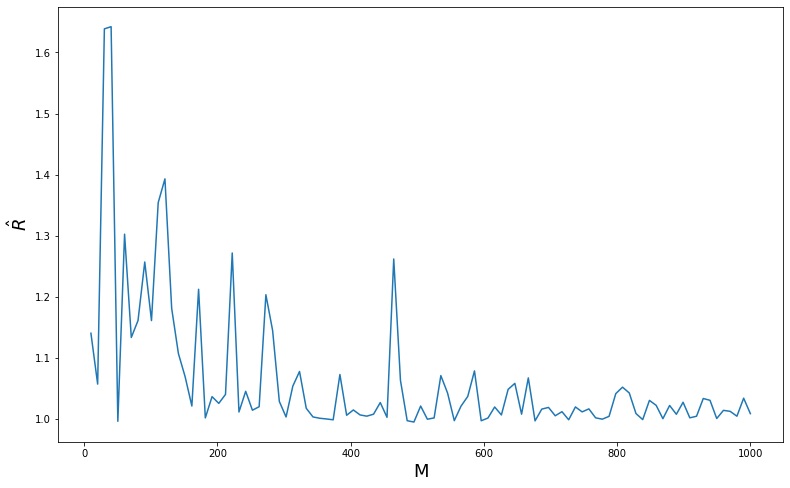

In [49]:
M = np.linspace(0, 1000, 100)
plt.plot(M, GR_vals[:, 0])
plt.xlabel("M", fontsize = 18)
plt.ylabel("$\hat{R}$", fontsize = 18)
plt.show()

It appears that M $\approx$ 300 or higher results in stable converged MCMC simulations.

## (iii) Let $R(x, y) = \sqrt{x^2 + y^2}$ be a scalar of interest. Plot the auto-correlation function of the samples $R$? Estimate the decorrelation time in units of Monte Carlo Steps (MCS).

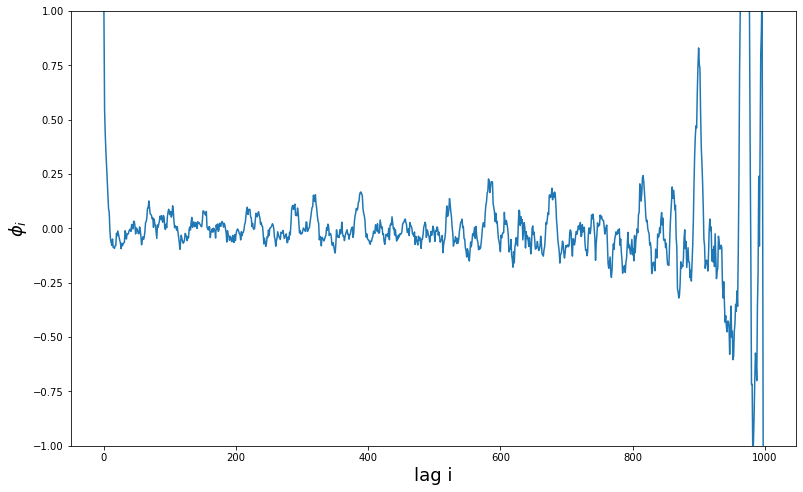

In [32]:
R = np.sqrt(rec[:, 0]**2 + rec[:, 1]**2)

def autocorr(x, NA = 0):
    """Given vector x, computes <x(t) x(0)>/<x(0) x(0)>
    If NA specified, NA elements of ACF are computed
    Otherwise, NA = N - 1 by default."""
    
    x = x - np.mean(x) # subtract mean from "x"
    N = len(x) # size of "x"
    
    # If NA is not specified
    if(NA == 0):
        NA = N - 1
        
    A = np.zeros((NA))
    
    # code: clarity > speed
    for i in range(NA):
        x1 = x[0:N-i-1] # both terms have N - i + 1 terms
        x2 = x[i:N-1]
        A[i] = np.mean(x1 * x2)
        
    return A / A[0]

ac = autocorr(R)
plt.plot(ac)
plt.xlabel("lag i", fontsize = 18)
plt.ylabel("$\phi_i$", fontsize = 18)
plt.ylim(-1, 1)
plt.show()

It appears to take about 10 Monte Carlo steps before the ACF falls to zero or decorrelates.

## (iv) Use block-averaging to estimate $\langle R \rangle$, and attach an errorbar to it.

In [56]:
def blockAverage(datastream, isplot=True, maxBlockSize=0):
    """use block average of correlated timeseries x,
    to provide error bounds for the estimated mean <x>.
    If maxBlockSize = 0, it is set to Nobs/4."""
    
    Nobs = len(datastream) # # observations
    minBlockSize = 1; # min: 1 obsv/block
    
    if maxBlockSize == 0:
        maxBlockSize = int(Nobs/4); # max: 4 blocs
        
    # total number of block-sizes
    NumBlocks = maxBlockSize - minBlockSize
    
    # mean and variance for each block size
    blockMean = np.zeros(NumBlocks)
    blockVar = np.zeros(NumBlocks)
    blockCtr = 0
    
    # blockSize is # observations/block
    # run them through all possibilities
    
    for blockSize in range(minBlockSize, maxBlockSize):
        
        # total number of such blocks in datastream
        Nblock = int(Nobs/blockSize)
        # container for parcelling block
        obsProp = np.zeros(Nblock)
        
        # Loop to chop datastream into blocks
        for i in range(1,Nblock+1):
            ibeg = (i-1) * blockSize
            iend = ibeg + blockSize
            obsProp[i-1] = np.mean(datastream[ibeg:iend])
            
        blockMean[blockCtr] = np.mean(obsProp)
        blockVar[blockCtr] = np.var(obsProp)/(Nblock - 1)
        blockCtr += 1
    v = np.arange(minBlockSize,maxBlockSize)
    
    if isplot:
        plt.subplot(2,1,1)
        plt.plot(v, np.sqrt(blockVar),'ro-',lw=2)
        plt.xlabel('block size', fontsize = 18)
        plt.ylabel('std', fontsize = 18)
        plt.subplot(2,1,2)
        plt.errorbar(v, blockMean, np.sqrt(blockVar))
        plt.ylabel('<x>', fontsize = 18)
        plt.xlabel('block size', fontsize = 18)
        plt.show()
        
    print("<x> = {0:f} +/- {1:f}\n"
          .format(blockMean[-1], np.sqrt(blockVar[-1])))
    
    return v, blockVar, blockMean

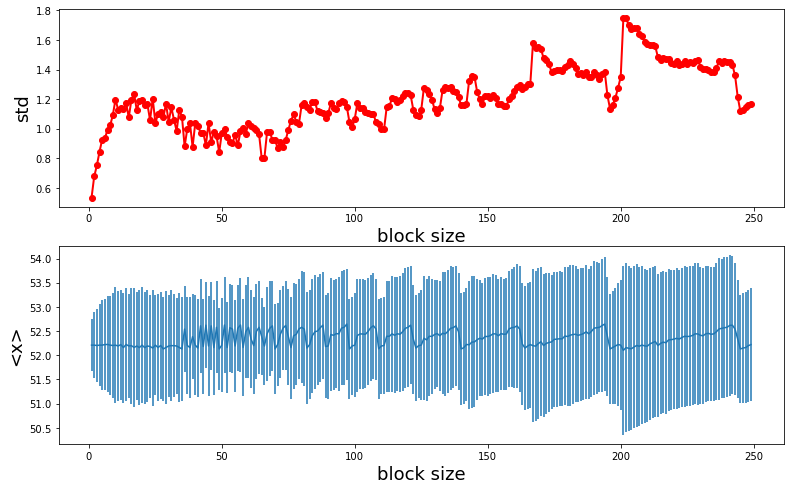

<x> = 52.219953 +/- 1.168086



In [58]:
v, blockVar, blockMean = blockAverage(R)